## Alignment and GATK-Spark Protocol

We demonstrate how by embedding Docker containers, we can distribute Jupyter notebooks that can run complicated workflows on the cloud interactively.

The example is a GATK variant calling pipeline that is run in a distributed manner using Spark on an auto-generated AWS kubernetes cluster

### Download the fastq input files
This step will take approximately 30 minutes, dependiMotivation
We demonstrate how by embedding Docker containers, we can distribute Jupyter notebooks that can run complicated workflows on the cloud interactively.

The example is a GATK variant calling pipeline that is run in a distributed manner using Spark on an auto-generated AWS kubernetes cluster

### Download the fastq input files
This step will take approximately 30 minutes, depending on your bandwidth.
The fastq files are publicly available with the following links: ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/HG00100/sequence_read/ERR013140_1.filt.fastq.gz ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/HG00100/sequence_read/ERR013140_2.filt.fastq.gz

To download the files we can use the parallel-fastq-dump container. This is a python wrapper around the fastq-dump utility that allows it to download separate chunks of the files separately.

```
docker run --rm -i -v /home/jovyan/work:/data biodepot/alpine-utils /bin/bash -c 'mkdir -p /data/fastq && cd /data/fastq && \
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/HG00100/sequence_read/ERR013140_1.filt.fastq.gz && \
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/HG00100/sequence_read/ERR013140_2.filt.fastq.gz'
```
{nbdocker#0}

### Download the reference and create the indices
Running two containers will take approximately 10 minutes.
We download the reference and generate the indices for bwa

Download the reference human transcriptome:
```
docker run --rm -i -v /home/jovyan/work:/data biodepot/alpine-utils /bin/bash -c 'mkdir -p /data/reference && wget -qO- "ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_genomic.fna.gz"| gunzip -c > /data/reference/GCh38.fa'
```
{nbdocker#1}

### Build indices using bwa:

```
docker run --rm -i -v  /home/jovyan/work:/data biodepot/alpine-bwa:3.7-0.7.15 /bin/bash -c 'cd /data/reference && bwa index  GCh38.fa'
```
{nbdocker#2}

### Alignment using bwa-mem to create bamfiles
Running alignment for each fastq input file will take approximately 30 minutes. 

```
docker run --rm -i -v /home/jovyan/work:/data biodepot/alpine-bwa-samtools:3.7-0.7.15-1.9-52-g651bf14 \
 /bin/bash -c 'mkdir -p /data/bams && bwa mem -t 8 \
  /data/fastq/ERR013140_1.fastq.gz /data/fastq/ERR013140_2.fastq.gz  | samtools sort -@8 -o data/bams/ERR013140.bam  - '
```
{nbdocker#3}

Results will be in: /home/jovyan/work/

### GATK (non-Spark steps)
Not all the components of GATK use Spark Add steps to download ref/ref.fasta and put in /data/references/ref.fasta

```
docker run --rm -i -v /home/jovyan/work:/data  \

broadinstitute/gatk:4.0.5.1 \

/bin/bash -c 'mkdir -p /data/variants && \
              cd /gatk/gatk_data/germline && \
              gatk HaplotypeCaller -R /data/references/ref.fasta -I /data/bams/ERR013140.bam -O /data/variants/variants.vcf '
```
{nbdocker#4}

```
docker run --rm -i -v /home/jovyan/work:/data \

broadinstitute/gatk:4.0.5.1 \

/bin/bash -c 'gatk ValidateSamFile -I /data/bams/ERR013140.bam -MODE SUMMARY'
{nbdocker#5}
```

### GATK (Spark steps)

About 1 minute
```
docker run --rm -i -v /.nbdocker/:/home/ubuntu/gatk_data \   
broadinstitute/gatk:4.0.5.1 \
/bin/bash -c ' gatk --java-options "-Xmx6G" MarkDuplicatesSpark \
-R /data/references/ref.fasta \
-I /data/bams/ERR013140.bam\
-O /data/bams/ERR013140.bam \
-M /data/bams/metrics.txt \
-- \
--spark-master local[*]'
```
{nbdocker#6}


## Visualization with igv

In [1]:
import igv

In [2]:
b = igv.Browser(
    {
        "genome": "hg19",
        "locus": "chr22:24,376,166-24,376,456"
    }
)

In [3]:
b.show()

In [10]:
b.load_track(
    {
        "name": "Local BAM",
        "url": "files/data/gstt1_sample.bam",
        "indexURL": "files/data/gstt1_sample.bam.bai",
        "format": "bam",
        "type": "alignment"
    })


'OK'

In [11]:
b.get_svg()

'OK'

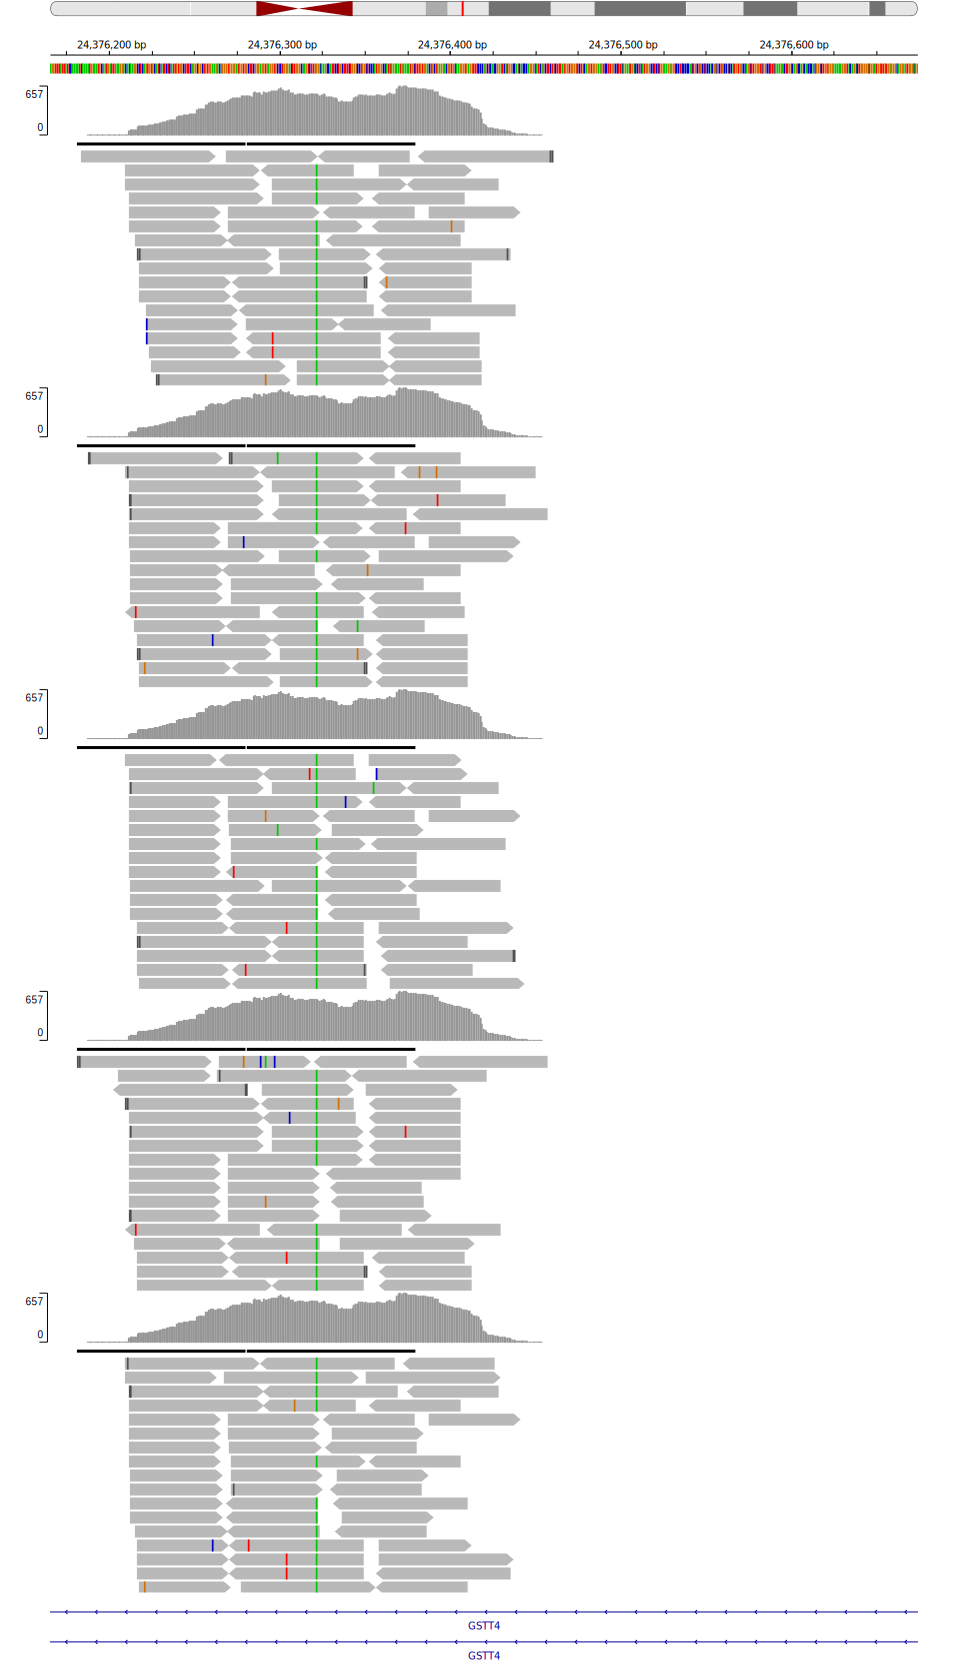

In [12]:
b.display_svg()